Train Part

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


class PositionDatasetCNN(Dataset):
    def __init__(self):
        self.actions = torch.cat([torch.load(f"actions_{i}.pt") for i in range(4)])
        self.positions = torch.cat([torch.load(f"positions_{i}.pt") for i in range(4)])
        self.imgs = torch.cat([torch.load(f"imgs_{i}.pt") for i in range(4)]).float() / 255.0  # Normalize

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        img = self.imgs[idx]  # (3, 128, 128)
        action = F.one_hot(self.actions[idx].long(), num_classes=4).float()  # One-hot encode action
        pos = self.positions[idx]  # (x, y)

        return img, action, pos


# Load dataset
cnn_dataset = PositionDatasetCNN()
cnn_dataloader = DataLoader(cnn_dataset, batch_size=32, shuffle=True)

In [2]:
import torch.nn as nn


class CNNPositionModel(nn.Module):
    def __init__(self):
        super(CNNPositionModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16 + 4, 128),  # Flattened CNN features + 4-action
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Predict (x, y)
        )

    def forward(self, img, action):
        img_features = self.conv(img)  # Extract CNN features
        img_features = img_features.view(img_features.size(0), -1)  # Flatten
        combined = torch.cat((img_features, action), dim=1)  # Combine image & action
        return self.fc(combined)

Epoch 1, Loss: 0.0249
Epoch 2, Loss: 0.0469
Epoch 3, Loss: 0.0018
Epoch 4, Loss: 0.0009
Epoch 5, Loss: 0.0007
Epoch 6, Loss: 0.0010
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0001


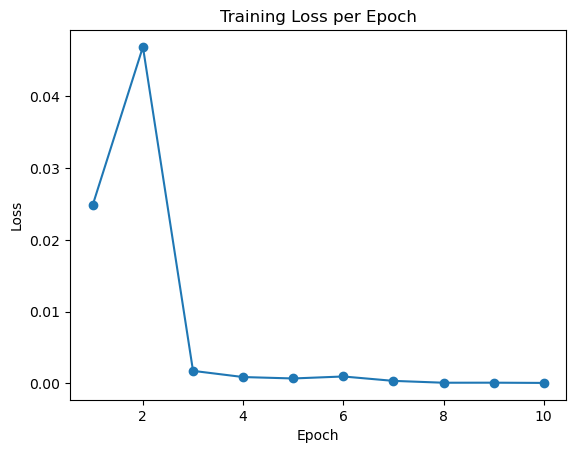

CNN model saved as hw1_2.pt!


In [3]:
import torch.optim as optim

# Initialize model, loss function, and optimizer
cnn_model = CNNPositionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
loss_values = []
# Training loop
for epoch in range(10):
    for img, action, pos in cnn_dataloader:
        optimizer.zero_grad()
        predictions = cnn_model(img, action)
        loss = criterion(predictions, pos)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    loss_values.append(loss.item())

# Plot training loss for each epoch
plt.plot(range(1, 11), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()

# Save trained model
torch.save(cnn_model.state_dict(), "hw1_2.pt")
print("CNN model saved as hw1_2.pt!")

Test Part

In [4]:
from homework1 import Hw1Env


def generate_test_data(N=5):
    """Mimics the main function but generates fewer samples for testing."""
    env = Hw1Env(render_mode="offscreen")
    positions = torch.zeros(N, 2, dtype=torch.float)
    actions = torch.zeros(N, dtype=torch.uint8)
    imgs = torch.zeros(N, 3, 128, 128, dtype=torch.uint8)

    for i in range(N):
        action_id = torch.randint(0, 4, (1,)).item()  # Random action
        env.step(action_id)
        obj_pos, pixels = env.state()

        positions[i] = torch.tensor(obj_pos)
        actions[i] = action_id
        imgs[i] = pixels
        env.reset()

    return actions, imgs, positions


# Generate test data
test_actions, test_imgs, test_positions = generate_test_data(N=5)

# Load trained model
cnn_model = CNNPositionModel()
cnn_model.load_state_dict(torch.load("hw1_2.pt"))
cnn_model.eval()

# Evaluate model
with torch.no_grad():
    print("\nEvaluation on Small Test Data:")
    print("=" * 50)

    for i in range(len(test_actions)):
        action_tensor = F.one_hot(test_actions[i].long(), num_classes=4).float()
        img_tensor = test_imgs[i].float() / 255.0  # Normalize image

        # Predict position
        predicted_pos = cnn_model(img_tensor.unsqueeze(0), action_tensor.unsqueeze(0)).squeeze(0)

        print(f"Sample {i+1}:")
        print(f"  Action Taken : {test_actions[i].item()}")
        print(f"  True Position: {test_positions[i].numpy()}")
        print(f"  Predicted Position: {predicted_pos.numpy()}")
        print("-" * 50)


Evaluation on Small Test Data:
Sample 1:
  Action Taken : 1
  True Position: [0.36991575 0.19571164]
  Predicted Position: [0.38703912 0.19836642]
--------------------------------------------------
Sample 2:
  Action Taken : 2
  True Position: [0.5391285  0.39189452]
  Predicted Position: [0.52691984 0.41262683]
--------------------------------------------------
Sample 3:
  Action Taken : 0
  True Position: [1.113326   0.02617635]
  Predicted Position: [1.1000855  0.04653393]
--------------------------------------------------
Sample 4:
  Action Taken : 1
  True Position: [0.37094328 0.19445564]
  Predicted Position: [0.38561502 0.1993256 ]
--------------------------------------------------
Sample 5:
  Action Taken : 0
  True Position: [ 0.8398705  -0.02811071]
  Predicted Position: [ 0.83973885 -0.01551784]
--------------------------------------------------
